In [82]:
#Importing libraries
import pandas as pd
from nltk.corpus import sentiwordnet as swn

In [9]:
#Read in word list
word_list = pd.read_csv('word_list.txt')

In [469]:
#Save as csv
df = pd.read_csv('all_training_final.csv')
df.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [472]:
df.shape

(79384, 3)

In [474]:
# Check for duplicates in 'Column1'
duplicates = df['text'].duplicated()

# Print rows with duplicates
len(df[duplicates])

10451

In [475]:
# Drop duplicate rows in 'Column1'
df = df.drop_duplicates(subset='text')
df.shape

(68933, 3)

In [445]:
#Importing libraries
import re, os, itertools, string
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import words
import numpy as np
import emoji
import utils
import time, os, utils
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\niamh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [476]:
#Functions used in initial preprocessing steps

#Define a function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

#Define a function to split hashtags within text
def split_hashtags_in_text(text):
    def split_hashtag(hashtag):
        split_words = []
        if hashtag != hashtag.lower() and hashtag != hashtag.upper():
            split_words = camel_case_split(hashtag)
        else:
            j = 0
            while j <= len(hashtag):
                loc = j
                for i in range(j + 1, len(hashtag) + 1, 1):
                    if hashtag[j:i].lower() in word_list:
                        loc = i
                if loc == j:
                    j += 1
                else:
                    split_words.append(hashtag[j:loc])
                    j = loc
        split_words = ['#' + str(s) for s in split_words]
        return split_words

    def camel_case_split(term):
        term = re.sub(r'([0-9]+)', r' \1', term)
        term = re.sub(r'(1st|2nd|3rd|4th|5th|6th|7th|8th|9th|0th)', r'\1 ', term)
        splits = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', term)
        return [s.group(0) for s in splits]

    #Find hashtags within the text using regex
    hashtags = re.findall(r'#\w+', text)
    
    #Split and flatten the hashtags
    split_hashtags = [split_hashtag(tag) for tag in hashtags]
    split_hashtags = [item for sublist in split_hashtags for item in sublist]
    
    #Replace the original hashtags in the text with the split words
    for hashtag in hashtags:
        text = text.replace(hashtag, ' '.join(split_hashtag(hashtag)))
    return text

#Define function to replace emoticons with emojis
def replace_emoticons(text, emoticons_to_emojis_dict):
    #Iterate through the dictionary and replace each emoticon with its corresponding emoji
    for emoticon, emoji in emoticons_to_emojis_dict.items():
        text = text.replace(emoticon, emoji)
    return text

In [477]:
def add_spaces_between_emojis(text):
    emoji_pattern = r'[\U0001F000-\U0001F6FF\U0001F900-\U0001F9FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F680-\U0001F6FF]'
    #Find all emojis in the text
    emojis = re.findall(emoji_pattern, text)
    #Iterate through found emojis and add spaces around each one
    for emoji in emojis:
        text = text.replace(emoji, f' {emoji} ')
    return text

#Apply the function 
for index, row in df.iterrows():
    text = row['text']
    text_with_spaces = add_spaces_between_emojis(text)
    df.at[index, 'text'] = text_with_spaces
df.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [478]:
#Define functions so that some punctuation symbols that convey tone are retained in the df
def add_spaces_around_special_characters(text):
    #Define a regular expression pattern to match the specified characters
    pattern = r'[?]|(\.{3})|[!]'
    #Use re.sub to add spaces around the matched characters 
    spaced_text = re.sub(pattern, lambda match: ' ' + match.group(0) + ' ' if match.group(0) else ' ... ', text)
    return spaced_text
#Apply the function 
for index, row in df.iterrows():
    text = row['text']
    text_with_spaces = add_spaces_around_special_characters(text)
    df.at[index, 'text'] = text_with_spaces
df.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [479]:
import re

def clean_text_dataframe(dataframe):
    # Convert 'text' column to strings
    dataframe['text'] = dataframe['text'].astype(str)
    print('Step 1 complete.')

    # Replace special characters with spaces
    dataframe['text'] = dataframe['text'].apply(lambda text: re.sub(r'([!*&%"~^+{}])', r' \1 ', text))
    print('Step 2 complete.')

    # Replace consecutive spaces with a single space
    dataframe['text'] = dataframe['text'].apply(lambda text: re.sub('\s{2,}', ' ', text))
    print('Step 3 complete.')

    # Iterate through each row and process the 'text' column
    for index, row in dataframe.iterrows():
        text = row['text']

        tokens = text.split()
        valid_tokens = [token for token in tokens if len(token) > 0]

        processed_text = ' '.join(valid_tokens)
        dataframe.at[index, 'text'] = processed_text
    print('Step 4 complete.')

    # Remove any hashtags relating to sarcasm
    dataframe['text'] = dataframe['text'].str.replace(r'\b\w*\.lower\(\)\.startswith\(\'#sarca\'\)\b', '', regex=True)
    print('Step 5 complete.')

    # Remove all URLs
    dataframe['text'] = dataframe['text'].apply(remove_urls)
    print('Step 6 complete.')

    # Replace user mentions with a generic @user
    dataframe['text'] = dataframe['text'].str.replace(r'@\w+', '@user', regex=True)
    print('Step 7 complete.')

    # Split hashtags into words
    dataframe['text'] = dataframe['text'].apply(split_hashtags_in_text)
    print('Step 8 complete.')

    # Make all words lowercase
    dataframe['text'] = dataframe['text'].str.lower()
    print('Step 9 complete.')

    return dataframe

# Test the function
df = clean_text_dataframe(df)
df.head()


Step 1 complete.
Step 2 complete.
Step 3 complete.
Step 4 complete.
Step 5 complete.
Step 6 complete.
Step 7 complete.
Step 8 complete.
Step 9 complete.


,text,label,source
0,the only thing i got from college was a caffei...,1,val
1,""" my (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. i...,1,val


In [480]:
#Define a function to remove characters missed before
def remove_special_characters(text):
    #Define a regular expression pattern to match the specified characters
    pattern = r'["\/\\().,:]'
    #Use re.sub to replace the matched characters with a space
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

#Apply the function
for index, row in df.iterrows():
    text = row['text']
    text_with_removed_characters = remove_special_characters(text)
    df.at[index, 'text'] = text_with_removed_characters
df.head()

,text,label,source
0,the only thing i got from college was a caffei...,1,val
1,my extended fam was discussing going on a ...,1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad i...,1,val


In [484]:
#Get stopwords
stopwords = set(stopwords.words('english'))

#Define function to remove stopwords from the text
def remove_stopwords(text):
    #Tokenize the text into words
    words = text.split()
    #Filter out stopwords
    words = [word for word in words if word.lower() not in stopwords]
    #Join the remaining words back into a string
    return ' '.join(words)

#Get lemmatiser
lemmatizer = WordNetLemmatizer()

#Define function to lemmatise the text
def lemmatize_text(text):
    lemmatized_tokens = []
    for token in text.split():
        token = token.lower()
        #Attempt lemmatization as a verb first
        lemmatized_token = lemmatizer.lemmatize(token, 'v')
        #If verb lemmatization doesn't work, try general lemmatization
        lemmatized_token = lemmatizer.lemmatize(lemmatized_token)
        lemmatized_tokens.append(lemmatized_token)
    return ' '.join(lemmatized_tokens)

#Define a function to apply these processing steps in a sequence
def clean_stopwords_lemmatize(dataframe):
    for index, row in dataframe.iterrows():
        dataframe.at[index, 'text'] = remove_stopwords(row['text'])
    print('Step 1 Complete.')
    
    for index, row in dataframe.iterrows():
        dataframe.at[index, 'text'] = lemmatize_text(row['text'])
        print('Step 2 Complete.')
        return dataframe
    
#Apply the function to the overall df
df_clean_a = clean_stopwords_lemmatize(df)
df_clean_a.head()

Step 1 Complete.
Step 2 Complete.


,text,label,source
0,thing get college caffeine addiction 😏,1,val
1,extended fam discussing going trip instead get...,1,val
2,love shoegaze sm 😁,1,val
3,men grimey 😢,1,val
4,okay like say song aint bad im unironically ja...,1,val


In [485]:
df_a_emoji = df_clean_a.copy()

In [486]:
#Importing libraries
from gensim.models import KeyedVectors
import gensim.downloader as api
from keras.preprocessing.text import Tokenizer
from numpy import zeros

In [487]:
#Create lists for emojis and vectors
emoji_list = []
vector_list = []

#Extract contents into lists
with open('emoji2vec.txt', 'r', encoding='utf-8') as file:
    for idx, line in enumerate(file):
        if idx == 0:
            continue 
        tokens = line.strip().split()
        emoji = tokens[0]
        vector = [float(v) for v in tokens[1:]]
        emoji_list.append(emoji)
        vector_list.append(vector)

#Confirm contents is all there
len(emoji_list), len(vector_list)

(1661, 1661)

In [455]:
#Create a dictionary to store the emoji vectors mapping
emoji_vectors = {}
for emoji, vector in zip(emoji_list, vector_list):
    #if len(vector) == vector_size:
        emoji_vectors[emoji] = vector

In [30]:
#Download the pre-trained Word2Vec model from Gensim data server (300d to match emoji vector)
word2vec_model = api.load('word2vec-google-news-300')

#Initialize an empty dictionary to store word vectors
word_vectors = {}

#Iterate through words in your vocabulary
for word in vocabulary:
    #Check if the word exists in the Word2Vec model
    if word in word2vec_model:
        #Get the word vector
        word_vector = word2vec_model[word]
        #Store the word vector in the dictionary
        word_vectors[word] = word_vector

In [457]:
#Combine the two dictionaries
all_vectors = {}

#Update the combined dictionary with emoji vectors then the word vectors
all_vectors.update(emoji_vectors)
all_vectors.update(word_vectors)

In [488]:
#Check how many vectors there are
len(all_vectors)

26681

In [489]:
#Define a function to build a vocabulary which accounts for word frequency
def build_vocabulary(dataframe):
    vocabulary = Counter()
    #Iterate through rows and split words out
    for index, row in dataframe.iterrows():
        text = row['text'] 
        vocabulary.update([word.lower() for word in text.split()])
    #Sort the vocabulary by word frequency
    vocabulary = sorted(vocabulary.items(), key=lambda pair: pair[1], reverse=False)
    #Create an indexed vocabulary with unique numerical indices
    counter = 1
    indexed_vocabulary = {}
    for (key, _) in vocabulary:
        indexed_vocabulary[key] = counter
        counter += 1
    #Add an token to handle OOV words
    indexed_vocabulary['unk'] = len(indexed_vocabulary) + 1
    print("Built vocabulary of size ", len(indexed_vocabulary))
    return indexed_vocabulary

In [490]:
#Get the vocabulary
vocabulary = build_vocabulary(df_a_emoji)

Built vocabulary of size  43658


In [509]:
#Create a tokenizer
tokenizer = Tokenizer()
#Fit the tokenizer to df
tokenizer.fit_on_texts(df_a_emoji["text"])

In [492]:
#Initialize an empty dictionary to store word vectors
word_vectors = {}

#Iterate through words in your vocabulary
for word in vocabulary:
    #Check if the word exists in the Word2Vec model
    if word in word2vec_model:
        #Get the word vector
        word_vector = word2vec_model[word]
        #Store the word vector in the dictionary
        word_vectors[word] = word_vector
        
print(len(word_vectors))

25020


In [502]:
#Add in emoji vectors
all_vectors = {}

#Update the combined dictionary with emoji vectors then the word vectors
all_vectors.update(emoji_vectors)
all_vectors.update(word_vectors)

print(len(all_vectors))

26681


In [503]:
#Calculate vocab length
vocab_length = len(tokenizer.word_index) + 1

In [504]:
#Generate vocab from the word tokens
vocab = list(tokenizer.word_index.keys())

In [505]:
#Check this is correct
vocab

['user',
 'a',
 'love',
 "i'm",
 'like',
 'day',
 'get',
 'people',
 'good',
 'great',
 'one',
 'time',
 'really',
 '😂',
 'u',
 'much',
 'know',
 'speak',
 'go',
 "can't",
 'life',
 'today',
 'see',
 'back',
 'want',
 'best',
 'need',
 'happy',
 'going',
 'work',
 'would',
 'wait',
 'got',
 'think',
 'school',
 'rt',
 'make',
 'never',
 'right',
 'hate',
 'always',
 '2',
 'night',
 'new',
 '️',
 'thanks',
 'say',
 'someone',
 'fun',
 "that's",
 'shit',
 'thank',
 'even',
 'first',
 'way',
 'well',
 'sleep',
 'better',
 'still',
 '3',
 'ever',
 '😊',
 'home',
 'getting',
 'could',
 'lol',
 'last',
 'yay',
 'feel',
 'oh',
 'thing',
 'look',
 'morning',
 'us',
 'nice',
 'come',
 'take',
 'im',
 '❤',
 'tomorrow',
 'awesome',
 'man',
 'please',
 "i've",
 '😍',
 'year',
 'something',
 'friends',
 'things',
 'class',
 '1',
 'next',
 'start',
 'tonight',
 'gonna',
 'hope',
 'every',
 'week',
 'made',
 'yeah',
 'world',
 'long',
 'game',
 'birthday',
 '5',
 "'",
 '4',
 'looking',
 'excited',
 'pe

In [497]:
#Create numpy array embedding matrix - start empty with a dimensionality of 300 corresponding to the vectors
embedding_matrix = zeros((vocab_length, 300))

#For each word in the vocab, check if it is present in the embeddings_dictionary
for index, word in enumerate(vocab):
    if index < vocab_length: 
        embedding_vector = all_vectors.get(word)
        #If it is there, the vector is added to the correct row in the embedding matrix - otherwise, it will just remain zeros
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
print('Matrix:')
print(embedding_matrix[2]) 

Matrix:
[ 0.10302734 -0.15234375  0.02587891  0.16503906 -0.16503906  0.06689453
  0.29296875 -0.26367188 -0.140625    0.20117188 -0.02624512 -0.08203125
 -0.02770996 -0.04394531 -0.23535156  0.16992188  0.12890625  0.15722656
  0.00756836 -0.06982422 -0.03857422  0.07958984  0.22949219 -0.14355469
  0.16796875 -0.03515625  0.05517578  0.10693359  0.11181641 -0.16308594
 -0.11181641  0.13964844  0.01556396  0.12792969  0.15429688  0.07714844
  0.26171875  0.08642578 -0.02514648  0.33398438  0.18652344 -0.20996094
  0.07080078  0.02600098 -0.10644531 -0.10253906  0.12304688  0.04711914
  0.02209473  0.05834961 -0.10986328  0.14941406 -0.10693359  0.01556396
  0.08984375  0.11230469 -0.04370117 -0.11376953 -0.0037384  -0.01818848
  0.24316406  0.08447266 -0.07080078  0.18066406  0.03515625 -0.09667969
 -0.21972656 -0.00328064 -0.03198242  0.18457031  0.28515625 -0.0859375
 -0.11181641  0.0213623  -0.30664062 -0.09228516 -0.18945312  0.01513672
  0.18554688  0.34375    -0.31054688  0.2255

In [498]:
#Check shape
df_a_emoji.shape

(68933, 3)

In [499]:
#Check for null values
df_a_emoji.isnull().sum()

text      0
label     0
source    0
dtype: int64

In [500]:
#Check for duplicates 
df_a_emoji.duplicated(subset=["text"]).sum()

8864

In [501]:
# Check for duplicates
duplicate_count = df_a_emoji.duplicated(subset=["text"]).sum()

# Drop duplicates based on the "text" column
df_a_emoji.drop_duplicates(subset=["text"], inplace=True)

# Print the number of duplicates removed
print(f"Dropped {duplicate_count} duplicates.")


Dropped 8864 duplicates.


In [506]:
#Tokenize the text
df_a_emoji["text"] = df_a_emoji["text"].apply(lambda x: word_tokenize(x))
df_a_emoji.head()

,text,label,source
0,"[thing, get, college, caffeine, addiction, 😏]",1,val
1,"[extended, fam, discussing, going, trip, inste...",1,val
2,"[love, shoegaze, sm, 😁]",1,val
3,"[men, grimey, 😢]",1,val
4,"[okay, like, say, song, aint, bad, im, unironi...",1,val


In [507]:
from nltk.tokenize import word_tokenize

In [508]:
#Check there are no rows with no tokens- remove if there are

#Count the tokens per row and find rows with zero tokens
zero_tokens = df_a_emoji['text'].apply(len) == 0

#Filter to find any rows with no tokens
rows_with_zero_tokens = df_a_emoji[zero_tokens]

# Check if there are any rows with zero tokens
if len(rows_with_zero_tokens) > 0:
    print("Rows with zero tokens:")
    print(rows_with_zero_tokens)
else:
    print("No rows with zero tokens found.")

Rows with zero tokens:
     text  label source
1544   []      0    val


In [510]:
#Drop rows with zero tokens
df_a_emoji = df_a_emoji[~zero_tokens]
df_a_emoji = df_a_emoji.reset_index(drop=True)
df_a_emoji.shape

(60068, 3)

In [511]:
#Define the maximum allowed sequence length
max_sequence_length = 38

#Create a boolean mask for rows with text length exceeding the maximum
mask = df_a_emoji['text'].apply(lambda x: len(x)) <= max_sequence_length

#Filter the df to keep only rows that meet the condition
df_filtered = df_a_emoji[mask]

#Reset index
df_a_emoji.reset_index(drop=True, inplace=True)
#Check df
df_a_emoji.head()

,text,label,source
0,"[thing, get, college, caffeine, addiction, 😏]",1,val
1,"[extended, fam, discussing, going, trip, inste...",1,val
2,"[love, shoegaze, sm, 😁]",1,val
3,"[men, grimey, 😢]",1,val
4,"[okay, like, say, song, aint, bad, im, unironi...",1,val


In [512]:
#Tokenise text to numeric form for NN

#Create a tokenizer
tokenizer = Tokenizer(num_words=vocab_length, oov_token="<OOV>")
tokenizer.fit_on_texts(df_a_emoji['text'])

#Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df_a_emoji['text'])

#Check one example
sequences[0]

[85, 15, 351, 5459, 2936, 574]

In [513]:
#Set the maximum sequence length
max_sequence_length = 38

#Iterate through the rows and pad the text data to the max length
for index, sequence in enumerate(sequences):
    if len(sequence) < max_sequence_length:
        #Pad the sequence with zeros at the end
        padded_sequence = sequence + [0] * (max_sequence_length - len(sequence))
    else:
        #Truncate the sequence if it's longer than the maximum length
        padded_sequence = sequence[:max_sequence_length]

    #Update the text column with the padded sequence
    df_a_emoji.at[index, 'text'] = padded_sequence
    
#Check the df
df_a_emoji.head()

,text,label,source
0,"[85, 15, 351, 5459, 2936, 574, 0, 0, 0, 0, 0, ...",1,val
1,"[4243, 1442, 3667, 39, 949, 411, 79, 4015, 484...",1,val
2,"[7, 18643, 4735, 380, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val
3,"[390, 18644, 1060, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val
4,"[316, 11, 65, 227, 1779, 150, 92, 9073, 3142, ...",1,val


In [321]:
# Define feature and label columns
X = df_a_emoji['text']
y = df_a_emoji['label']

# Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert training data and labels to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Check the data shape (optional)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# Check the data shape (optional)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (48054,)
y_train shape: (48054,)
X_test shape: (12014,)
y_test shape: (12014,)


In [323]:
# Define the maximum sequence length you want to use
maxlen = 38  # Adjust this value as needed

# Initialize an empty list to store the padded sequences
X_train_padded = []

# Iterate through the tokenized sequences and pad each one
for sequence in X_train:
    # Check the length of the sequence
    if len(sequence) < maxlen:
        # If it's shorter than maxlen, pad it with zeros at the end (not the beginning)
        padded_sequence = sequence + [0] * (maxlen - len(sequence))
    else:
        # If it's longer than maxlen, truncate it to maxlen
        padded_sequence = sequence[:maxlen]
    
    # Add the padded sequence to the list
    X_train_padded.append(padded_sequence)

# Convert the list of lists to a NumPy array
X_train_padded = np.array(X_train_padded)

# Now X_train_padded is a NumPy array of shape (number_of_samples, maxlen)
# Check the data shape (optional)
print("X_train shape:", X_train_padded.shape)
print("y_train shape:", y_train.shape)
# Check the data shape (optional)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(X_train_padded[10])

X_train shape: (48054, 38)
y_train shape: (48054,)
X_test shape: (12014,)
y_test shape: (12014,)
[ 990  192  767  201  187 6358 1913   31  800    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [324]:
# Define the maximum sequence length you want to use
maxlen = 38  # Adjust this value as needed

# Initialize an empty list to store the padded sequences
X_test_padded = []

# Iterate through the tokenized sequences and pad each one
for sequence in X_test:
    # Check the length of the sequence
    if len(sequence) < maxlen:
        # If it's shorter than maxlen, pad it with zeros at the end (not the beginning)
        padded_sequence = sequence + [0] * (maxlen - len(sequence))
    else:
        # If it's longer than maxlen, truncate it to maxlen
        padded_sequence = sequence[:maxlen]
    
    # Add the padded sequence to the list
    X_test_padded.append(padded_sequence)

# Convert the list of lists to a NumPy array
X_test_padded = np.array(X_test_padded)

# Check the data shape (optional)
print("X_train shape:", X_train_padded.shape)
print("y_train shape:", y_train.shape)
# Check the data shape (optional)
print("X_test shape:", X_test_padded.shape)
print("y_test shape:", y_test.shape)
print(X_train_padded[10])

X_train shape: (48054, 38)
y_train shape: (48054,)
X_test shape: (12014, 38)
y_test shape: (12014,)
[ 990  192  767  201  187 6358 1913   31  800    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


# Create sentiment embedding

In [379]:
#Importing libraries
import collections
import matplotlib.pyplot as plt

In [515]:
#Check vocab 
vocab

['user',
 'a',
 'love',
 "i'm",
 'like',
 'day',
 'get',
 'people',
 'good',
 'great',
 'one',
 'time',
 'really',
 '😂',
 'u',
 'much',
 'know',
 'speak',
 'go',
 "can't",
 'life',
 'today',
 'see',
 'back',
 'want',
 'best',
 'need',
 'happy',
 'going',
 'work',
 'would',
 'wait',
 'got',
 'think',
 'school',
 'rt',
 'make',
 'never',
 'right',
 'hate',
 'always',
 '2',
 'night',
 'new',
 '️',
 'thanks',
 'say',
 'someone',
 'fun',
 "that's",
 'shit',
 'thank',
 'even',
 'first',
 'way',
 'well',
 'sleep',
 'better',
 'still',
 '3',
 'ever',
 '😊',
 'home',
 'getting',
 'could',
 'lol',
 'last',
 'yay',
 'feel',
 'oh',
 'thing',
 'look',
 'morning',
 'us',
 'nice',
 'come',
 'take',
 'im',
 '❤',
 'tomorrow',
 'awesome',
 'man',
 'please',
 "i've",
 '😍',
 'year',
 'something',
 'friends',
 'things',
 'class',
 '1',
 'next',
 'start',
 'tonight',
 'gonna',
 'hope',
 'every',
 'week',
 'made',
 'yeah',
 'world',
 'long',
 'game',
 'birthday',
 '5',
 "'",
 '4',
 'looking',
 'excited',
 'pe

In [384]:
#Make the list a df
df_vocab = pd.DataFrame(vocab, columns=["word"])
df_vocab.head()

,word
0,user
1,a
2,love
3,like
4,i'm


In [385]:
# Function to calculate positivity score for a word
def calculate_positivity_score(word):
    # Initialize positivity score to 0.0
    pos_score = 0.0
    
    # Use SentiWordNet to get the positivity score
    synsets = list(swn.senti_synsets(word))
    
    # Calculate the average positivity score if synsets are found
    if synsets:
        pos_scores = [synset.pos_score() for synset in synsets]
        pos_score = sum(pos_scores) / len(synsets)
    
    return pos_score

# Apply the function to each row in the DataFrame and create a new column
df_vocab["pos_score"] = df_vocab["word"].apply(calculate_positivity_score)

# Display the DataFrame with the positivity scores
df_vocab.head()

,word,pos_score
0,user,0.000000
1,a,0.017857
2,love,0.387500
3,like,0.284091
4,i'm,0.000000


In [386]:
# Function to calculate negativity score for a word
def calculate_neg_score(word):
    # Initialize negativity score to 0.0
    neg_score = 0.0
    
    # Use SentiWordNet to get the negativity score
    synsets = list(swn.senti_synsets(word))
    
    # Calculate the average negativity score if synsets are found
    if synsets:
        neg_scores = [synset.neg_score() for synset in synsets]
        neg_score = sum(neg_scores) / len(synsets)
    
    return neg_score

# Apply the function to each row in the DataFrame and create a new column
df_vocab["neg_score"] = df_vocab["word"].apply(calculate_neg_score)

# Display the DataFrame with the positivity scores
df_vocab.head()

,word,pos_score,neg_score
0,user,0.000000,0.000000
1,a,0.017857,0.035714
2,love,0.387500,0.012500
3,like,0.284091,0.022727
4,i'm,0.000000,0.000000


In [410]:
import seaborn as sns

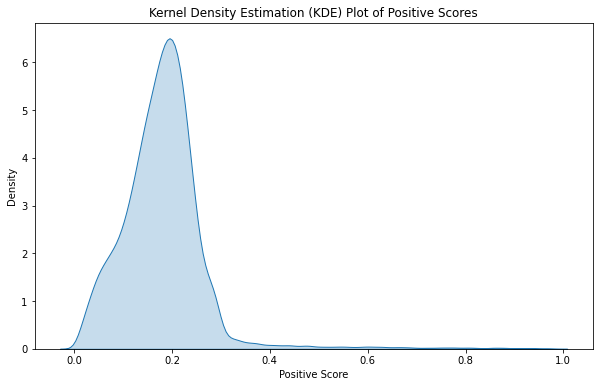

In [411]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vocab, x='pos_score', fill=True)
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Positive Scores')
plt.show()

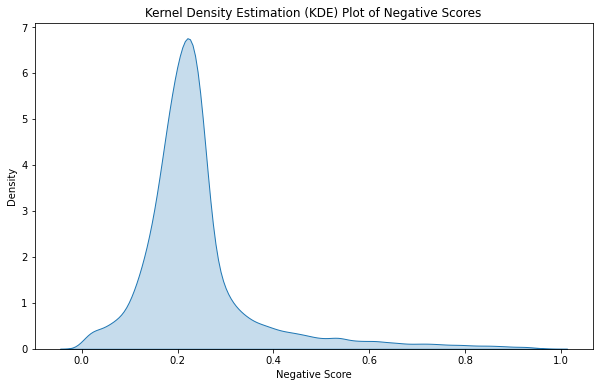

In [413]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vocab, x='neg_score', fill=True)
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Negative Scores')
plt.show()

In [85]:
emotion_info = pd.read_csv('emoji_emotion_stats_all.csv')
emotion_info.head()

,emoji,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut,pred_sent_score
0,🇸🇰,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088,0.092526
1,👔,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700,-0.217531
2,🌀,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024,0.322716
3,🚾,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141,0.108159
4,👹,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231,-0.013007


In [397]:
df_emoji = pd.DataFrame()
df_emoji['word'] = emotion_info['emoji']
df_emoji['pos_score'] = emotion_info['pred_pos']
df_emoji['neg_score'] = emotion_info['pred_neg']
df_emoji.head()

,word,pos_score,neg_score
0,🇸🇰,0.154219,0.061693
1,👔,0.099384,0.316915
2,🌀,0.409846,0.087130
3,🚾,0.254009,0.145850
4,👹,0.172381,0.185388


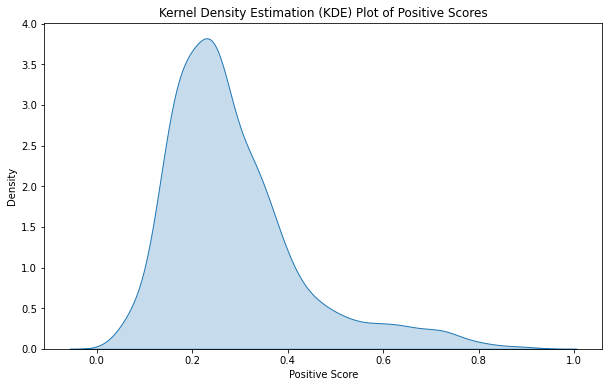

In [414]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_emoji, x='pos_score', fill=True)
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Positive Scores')
plt.show()

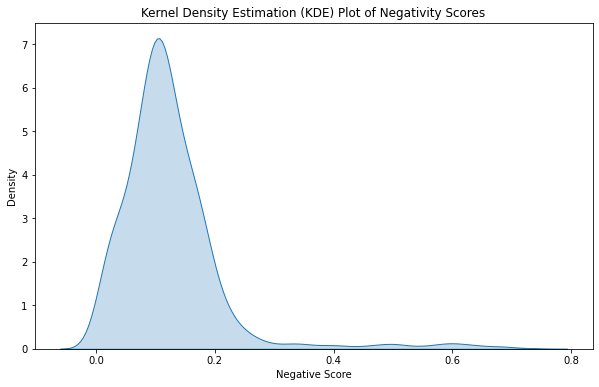

In [415]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_emoji, x='neg_score', fill=True)
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Negativity Scores')
plt.show()

In [399]:
print(df_vocab.shape)
df_vocab = df_vocab[~df_vocab['word'].isin(df_emoji['word'])]
print(df_vocab.shape)

(38385, 3)
(37878, 3)


In [400]:
# Concatenate along rows (axis=0)
df_embedding = pd.concat([df_vocab, df_emoji], axis=0)
df_embedding.head()

,word,pos_score,neg_score
0,user,0.292249,0.230560
1,a,0.255146,0.242248
2,love,0.548703,0.085357
3,like,0.241746,0.199435
4,i'm,0.184428,0.229113


In [401]:
#Check for duplicates 
df_embedding.duplicated(subset=["word"]).sum()

0

In [402]:
df_embedding.shape

(39553, 3)

In [416]:
from sklearn.preprocessing import MinMaxScaler

In [420]:
# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit the scaler to your 'pos_score' column and transform it
df_vocab['scaled_pos_score'] = scaler.fit_transform(df_vocab['pos_score'].values.reshape(-1, 1))
df_vocab['scaled_neg_score'] = scaler.fit_transform(df_vocab['neg_score'].values.reshape(-1, 1))

In [417]:
# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit the scaler to your 'pos_score' column and transform it
df_emoji['scaled_pos_score'] = scaler.fit_transform(df_emoji['pos_score'].values.reshape(-1, 1))
df_emoji['scaled_neg_score'] = scaler.fit_transform(df_emoji['neg_score'].values.reshape(-1, 1))

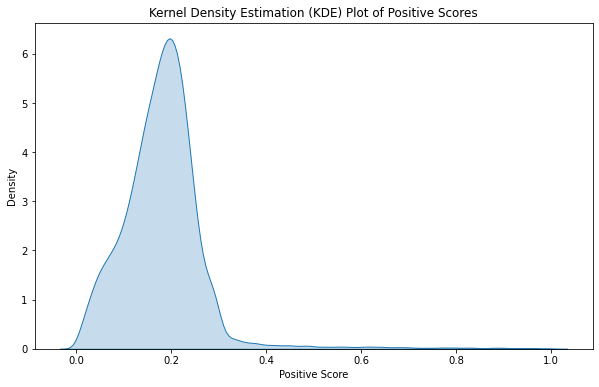

In [423]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vocab, x='scaled_pos_score', fill=True)
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Positive Scores')
plt.show()

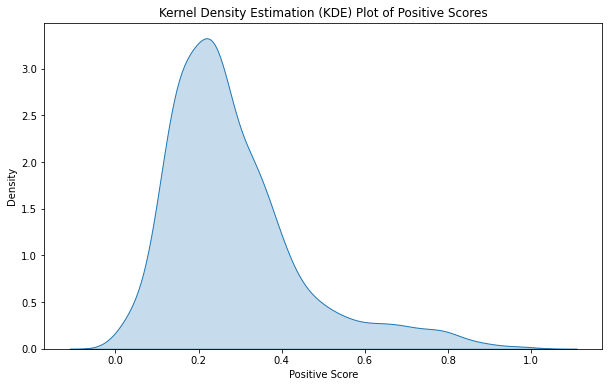

In [424]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_emoji, x='scaled_pos_score', fill=True)
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Positive Scores')
plt.show()

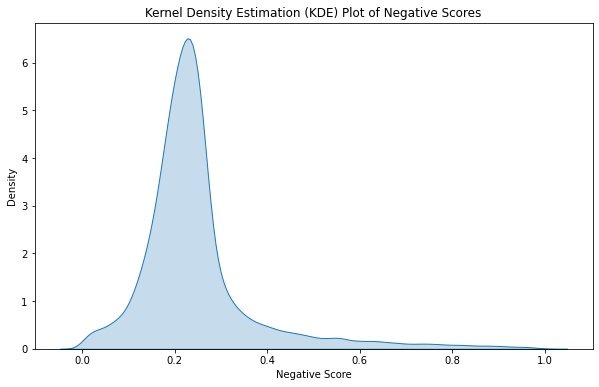

In [425]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vocab, x='scaled_neg_score', fill=True)
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Negative Scores')
plt.show()

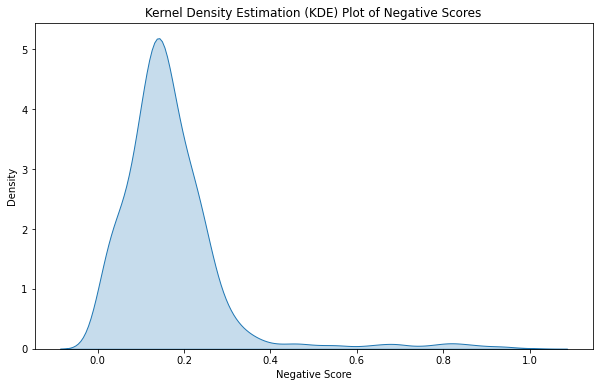

In [426]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_emoji, x='scaled_neg_score', fill=True)
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Negative Scores')
plt.show()

In [427]:
# Concatenate along rows (axis=0)
df_embedding = pd.concat([df_vocab, df_emoji], axis=0)
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score
0,user,0.292249,0.230560,0.297030,0.237535
1,a,0.255146,0.242248,0.258824,0.249660
2,love,0.548703,0.085357,0.561111,0.086891
3,like,0.241746,0.199435,0.245026,0.205244
4,i'm,0.184428,0.229113,0.186003,0.236033


In [516]:
#Convert text to sequences of integers
df_embedding['word_token'] = tokenizer.texts_to_sequences(df_embedding['word'])

#Check one example
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score,word_token
0,user,0.292249,0.230560,0.297030,0.237535,[4]
1,a,0.255146,0.242248,0.258824,0.249660,[6]
2,love,0.548703,0.085357,0.561111,0.086891,[7]
3,like,0.241746,0.199435,0.245026,0.205244,[11]
4,i'm,0.184428,0.229113,0.186003,0.236033,[1]


In [522]:
#Convert text to sequences of integers
df_embedding['sent_score'] = df_embedding['scaled_pos_score'] - df_embedding['scaled_neg_score']

#Check one example
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score,word_token,sent_score
0,user,0.292249,0.230560,0.297030,0.237535,[4],0.059495
1,a,0.255146,0.242248,0.258824,0.249660,[6],0.009164
2,love,0.548703,0.085357,0.561111,0.086891,[7],0.474220
3,like,0.241746,0.199435,0.245026,0.205244,[11],0.039782
4,i'm,0.184428,0.229113,0.186003,0.236033,[1],-0.050031


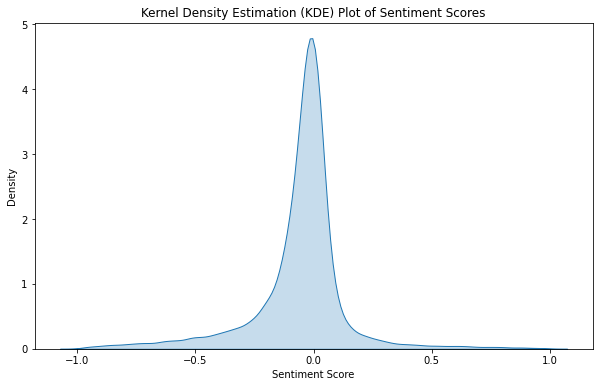

In [523]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_embedding, x='sent_score', fill=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Sentiment Scores')
plt.show()

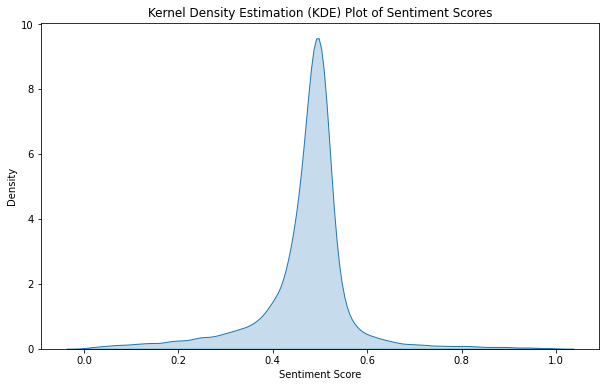

In [524]:
# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit the scaler to your 'pos_score' column and transform it
df_embedding['sent_score'] = scaler.fit_transform(df_embedding['sent_score'].values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_embedding, x='sent_score', fill=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Sentiment Scores')
plt.show()

In [520]:
# Initialize an empty dictionary to store sentiment scores
sentiment_scores_pos = {}

# Iterate through the DataFrame rows
for index, row in df_embedding.iterrows():
    word_token = row['word_token']
    
    # Check if word_token is not empty and has at least one element
    if word_token and len(word_token) > 0:
        word = word_token[0]
        pos_score = row['scaled_pos_score']
        word_sentiment = pos_score

        # Add the nested dictionary to the main sentiment_scores dictionary
        sentiment_scores_pos[word] = word_sentiment

# Print the resulting dictionary
sentiment_scores_pos

{4: 0.29702993575100584,
 6: 0.25882390380748005,
 7: 0.5611111399642895,
 11: 0.2450256026633217,
 1: 0.8290715644503451,
 13: 0.3031782197991245,
 15: 0.24753360073438177,
 14: 0.12777592562537,
 16: 0.6788331764842753,
 18: 0.6484524704687227,
 19: 0.2657893341607003,
 21: 0.2653608594278416,
 23: 0.17603903781289182,
 24: 0.25124414834307485,
 26: 0.17712388108796367,
 27: 0.2526812204353925,
 28: 0.3020920569127138,
 30: 0.2647819490023549,
 31: 0.15069086911414845,
 34: 0.22378826879415967,
 35: 0.26128577685895216,
 36: 0.29285443996582117,
 37: 0.4542075533978583,
 39: 0.210240187441891,
 40: 0.19352803101838903,
 41: 0.19465678973127212,
 38: 0.25652774938925793,
 42: 0.19902791022528127,
 43: 0.15510283618239012,
 44: 0.7824873582276674,
 32: 0.15538408218506045,
 45: 0.12766167183433483,
 46: 0.1536724542126741,
 47: 0.12534790213917096,
 49: 0.2484998170878188,
 52: 0.2748437399519443,
 50: 0.2091457232794999,
 51: 0.25831965883286323,
 55: 0.33563648508018823,
 54: 0.27624

In [521]:
# Initialize an empty dictionary to store sentiment scores
sentiment_scores_neg = {}

# Iterate through the DataFrame rows
for index, row in df_embedding.iterrows():
    word_token = row['word_token']
    
    # Check if word_token is not empty and has at least one element
    if word_token and len(word_token) > 0:
        word = word_token[0]
        pos_score = row['scaled_neg_score']
        word_sentiment = pos_score

        # Add the nested dictionary to the main sentiment_scores dictionary
        sentiment_scores_neg[word] = word_sentiment

# Print the resulting dictionary
sentiment_scores_neg

{4: 0.23753499447764087,
 6: 0.2496603888015744,
 7: 0.08689108910814557,
 11: 0.20524355078142215,
 1: 0.014044823122252189,
 13: 0.1878016864022928,
 15: 0.24879714920316995,
 14: 0.29812324020332737,
 16: 0.05791649117737864,
 18: 0.05869467680883304,
 19: 0.24364918702996716,
 21: 0.22715170884305702,
 23: 0.22553492982336953,
 24: 0.2530641861800784,
 26: 0.26521835051946047,
 27: 0.2567208845165205,
 28: 0.20915822077170065,
 30: 0.23550116617974,
 31: 0.11418272616208627,
 34: 0.24178697396124102,
 35: 0.2352489145182281,
 36: 0.1636461897346648,
 37: 0.09975474119819241,
 39: 0.18453951294185642,
 40: 0.2122504331629048,
 41: 0.2349345777508369,
 38: 0.16638923524305296,
 42: 0.2905509906886001,
 43: 0.3189755186007308,
 44: 0.01683278350893458,
 32: 0.285777425202196,
 45: 0.2979345422943726,
 46: 0.2438272333856473,
 47: 0.21285199084218115,
 49: 0.19324119813022098,
 52: 0.23953026693538665,
 50: 0.343808509710603,
 51: 0.1913815049500054,
 55: 0.2043512474382336,
 54: 0.230

In [526]:
# Initialize an empty dictionary to store sentiment scores
sentiment_scores = {}

# Iterate through the DataFrame rows
for index, row in df_embedding.iterrows():
    word_token = row['word_token']
    
    # Check if word_token is not empty and has at least one element
    if word_token and len(word_token) > 0:
        word = word_token[0]
        pos_score = row['sent_score']
        word_sentiment = pos_score

        # Add the nested dictionary to the main sentiment_scores dictionary
        sentiment_scores[word] = word_sentiment

# Print the resulting dictionary
sentiment_scores

{4: 0.5296684003246906,
 6: 0.5044847583857666,
 7: 0.737178686389567,
 11: 0.519804933603557,
 1: 0.9077034320549655,
 13: 0.5576291022435281,
 15: 0.4992675123727941,
 14: 0.4146653991572762,
 16: 0.8105792591454692,
 18: 0.7949887140597385,
 19: 0.5109776969182095,
 21: 0.5190179226640831,
 23: 0.47513415952134913,
 24: 0.4989890694588683,
 26: 0.4558211214215081,
 27: 0.4978784656728117,
 28: 0.5463997591919163,
 30: 0.5145505583651523,
 31: 0.5181668129234168,
 34: 0.4908939727110722,
 35: 0.5129274425913182,
 36: 0.5645498877246546,
 37: 0.6772524041834845,
 39: 0.5127592289158472,
 40: 0.490531866430691,
 41: 0.47974649514302026,
 38: 0.5450011024590997,
 42: 0.4541055945831782,
 43: 0.41790502159768866,
 44: 0.8829997616476976,
 32: 0.43465661713863935,
 45: 0.4147026477343418,
 46: 0.45479023263769147,
 47: 0.4561165220881779,
 49: 0.5275487301255742,
 52: 0.517569052396404,
 50: 0.4325203745921934,
 51: 0.5333926580128527,
 55: 0.5655891212839669,
 54: 0.5229734228045675,
 57

In [103]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler(feature_range=(1, 10))

# Fit and transform the pos_score column
df_uniquesent_embedding['pos_score_scaled'] = scaler.fit_transform(df_uniquesent_embedding[['pos_score']])

# Round the scaled values to the nearest integer
df_uniquesent_embedding['pos_score_scaled'] = df_uniquesent_embedding['pos_score_scaled'].round().astype(int)

# Print the DataFrame with the rounded scaled column
df_uniquesent_embedding.head()

,word,pos_score,neg_score,pos_score_scaled
7337,kudos,1.0,0.0,10
20220,researcher,1.0,0.0,10
30482,fantabulous,1.0,0.0,10
1910,bliss,1.0,0.0,10
9462,researchers,1.0,0.0,10


In [104]:
# Fit and transform the pos_score column
df_uniquesent_embedding['neg_score_scaled'] = scaler.fit_transform(df_uniquesent_embedding[['neg_score']])

# Round the scaled values to the nearest integer
df_uniquesent_embedding['neg_score_scaled'] = df_uniquesent_embedding['neg_score_scaled'].round().astype(int)

# Print the DataFrame with the rounded scaled column
df_uniquesent_embedding.head()

,word,pos_score,neg_score,pos_score_scaled,neg_score_scaled
7337,kudos,1.0,0.0,10,1
20220,researcher,1.0,0.0,10,1
30482,fantabulous,1.0,0.0,10,1
1910,bliss,1.0,0.0,10,1
9462,researchers,1.0,0.0,10,1


In [119]:
#Convert text to sequences of integers
df_uniquesent_embedding['word_token'] = tokenizer.texts_to_sequences(df_uniquesent_embedding['word'])

#Check one example
df_uniquesent_embedding.head()

,word,pos_score,neg_score,pos_score_scaled,neg_score_scaled,word_token
7337,kudos,1.0,0.0,10,1,[7288]
20220,researcher,1.0,0.0,10,1,[19998]
30482,fantabulous,1.0,0.0,10,1,[30415]
1910,bliss,1.0,0.0,10,1,[1923]
9462,researchers,1.0,0.0,10,1,[9404]


In [125]:
# Initialize an empty dictionary to store sentiment scores
sentiment_scores_pos = {}

# Iterate through the DataFrame rows
for index, row in df_uniquesent_embedding.iterrows():
    word_token = row['word_token']
    
    # Check if word_token is not empty and has at least one element
    if word_token and len(word_token) > 0:
        word = word_token[0]
        pos_score = row['pos_score_scaled']
        word_sentiment = pos_score

        # Add the nested dictionary to the main sentiment_scores dictionary
        sentiment_scores_pos[word] = word_sentiment

# Print the resulting dictionary
sentiment_scores_pos

{7288: 10,
 19998: 10,
 30415: 10,
 1923: 10,
 9404: 10,
 1527: 10,
 2758: 9,
 1249: 9,
 1: 1,
 2771: 9,
 37214: 9,
 4236: 9,
 2380: 9,
 24698: 9,
 207: 1,
 27581: 9,
 14522: 9,
 11618: 9,
 5570: 9,
 99: 9,
 3782: 9,
 64: 8,
 96: 8,
 29724: 8,
 9165: 8,
 6435: 8,
 10984: 8,
 903: 8,
 16068: 8,
 2892: 8,
 2434: 8,
 380: 8,
 381: 8,
 1542: 8,
 16434: 8,
 25730: 8,
 21396: 8,
 18415: 8,
 27710: 8,
 20117: 8,
 1896: 8,
 19929: 8,
 4043: 8,
 2062: 8,
 32776: 8,
 900: 8,
 23332: 8,
 16701: 8,
 777: 8,
 20271: 8,
 17872: 8,
 16454: 8,
 6115: 8,
 16253: 8,
 33096: 8,
 20693: 8,
 2507: 8,
 32656: 8,
 34910: 8,
 23109: 8,
 6497: 8,
 4465: 8,
 7197: 8,
 3732: 7,
 8069: 7,
 6518: 7,
 21538: 7,
 6046: 7,
 24572: 7,
 20338: 7,
 9293: 7,
 5009: 7,
 906: 7,
 33074: 7,
 199: 7,
 9414: 7,
 19850: 7,
 8877: 7,
 4246: 7,
 4979: 7,
 17814: 7,
 29385: 7,
 16147: 7,
 13873: 7,
 709: 7,
 4550: 7,
 1192: 7,
 1850: 7,
 377: 7,
 9328: 7,
 3946: 7,
 23048: 7,
 13378: 7,
 17516: 7,
 5934: 7,
 4461: 7,
 860: 7,
 17

In [126]:
# Initialize an empty dictionary to store sentiment scores
sentiment_scores_neg = {}

# Iterate through the DataFrame rows
for index, row in df_uniquesent_embedding.iterrows():
    word_token = row['word_token']
    
    # Check if word_token is not empty and has at least one element
    if word_token and len(word_token) > 0:
        word = word_token[0]
        neg_score = row['neg_score_scaled']
        word_sentiment = neg_score

        # Add the nested dictionary to the main sentiment_scores dictionary
        sentiment_scores_neg[word] = word_sentiment

# Print the resulting dictionary
sentiment_scores_neg

{7288: 1,
 19998: 1,
 30415: 1,
 1923: 1,
 9404: 1,
 1527: 1,
 2758: 1,
 1249: 1,
 1: 1,
 2771: 2,
 37214: 1,
 4236: 1,
 2380: 1,
 24698: 2,
 207: 1,
 27581: 1,
 14522: 1,
 11618: 1,
 5570: 1,
 99: 2,
 3782: 1,
 64: 1,
 96: 1,
 29724: 1,
 9165: 1,
 6435: 1,
 10984: 1,
 903: 1,
 16068: 1,
 2892: 1,
 2434: 1,
 380: 1,
 381: 1,
 1542: 3,
 16434: 1,
 25730: 1,
 21396: 2,
 18415: 1,
 27710: 1,
 20117: 3,
 1896: 1,
 19929: 1,
 4043: 2,
 2062: 1,
 32776: 1,
 900: 1,
 23332: 1,
 16701: 1,
 777: 2,
 20271: 1,
 17872: 1,
 16454: 2,
 6115: 1,
 16253: 2,
 33096: 3,
 20693: 1,
 2507: 2,
 32656: 1,
 34910: 1,
 23109: 1,
 6497: 1,
 4465: 1,
 7197: 1,
 3732: 1,
 8069: 1,
 6518: 1,
 21538: 1,
 6046: 1,
 24572: 1,
 20338: 1,
 9293: 2,
 5009: 1,
 906: 1,
 33074: 1,
 199: 1,
 9414: 1,
 19850: 2,
 8877: 2,
 4246: 1,
 4979: 2,
 17814: 1,
 29385: 1,
 16147: 1,
 13873: 1,
 709: 1,
 4550: 1,
 1192: 1,
 1850: 1,
 377: 1,
 9328: 3,
 3946: 2,
 23048: 3,
 13378: 2,
 17516: 1,
 5934: 2,
 4461: 2,
 860: 1,
 17268: 1

In [127]:
# Define the dimension of one-hot encoding (e.g., number of intensity levels)
ds = 11

# Initialize an empty dictionary for one-hot encoded values
one_hot_encoded_sentiments_pos = {}

# Iterate through the original dictionary
for word, sentiment_intensity in sentiment_scores_pos.items():
    # Create a one-hot encoded array filled with zeros
    one_hot_array = np.zeros(ds)
    
    # Set the corresponding index to 1 based on sentiment intensity
    one_hot_array[sentiment_intensity] = 1
    
    # Add the word and its one-hot encoded array to the new dictionary
    one_hot_encoded_sentiments_pos[word] = one_hot_array

# one_hot_encoded_sentiments now contains the one-hot encoded values
one_hot_encoded_sentiments_pos

{7288: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 19998: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 30415: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 1923: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 9404: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 1527: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 2758: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 1249: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 1: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2771: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 37214: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 4236: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 2380: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 24698: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 207: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 27581: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 14522: array([0., 0., 0., 0., 0., 0., 

In [128]:
# Define the dimension of one-hot encoding (e.g., number of intensity levels)
ds = 11

# Initialize an empty dictionary for one-hot encoded values
one_hot_encoded_sentiments_neg = {}

# Iterate through the original dictionary
for word, sentiment_intensity in sentiment_scores_neg.items():
    # Create a one-hot encoded array filled with zeros
    one_hot_array = np.zeros(ds)
    
    # Set the corresponding index to 1 based on sentiment intensity
    one_hot_array[sentiment_intensity] = 1
    
    # Add the word and its one-hot encoded array to the new dictionary
    one_hot_encoded_sentiments_neg[word] = one_hot_array

# one_hot_encoded_sentiments now contains the one-hot encoded values
print(one_hot_encoded_sentiments_neg)

{7288: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 19998: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 30415: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1923: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 9404: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1527: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 2758: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1249: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 2771: array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 37214: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 4236: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 2380: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 24698: array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 207: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 27581: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 14522: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 

In [131]:
# Define the dimension of sentiment embeddings and the number of intensity levels
ds = 11

# Initialize an empty dictionary for the combined sentiment embeddings
combined_sentiment_embeddings = {}

# Iterate through the words in both dictionaries (sentiment_scores_pos and sentiment_scores_neg)
for word in set(sentiment_scores_pos.keys()).union(sentiment_scores_neg.keys()):
    # Initialize one-hot encoded arrays for positive and negative sentiment
    spi = np.zeros(ds)
    sni = np.zeros(ds)

    # Get positive sentiment intensity from sentiment_scores_pos if the word is present
    if word in sentiment_scores_pos:
        spi[sentiment_scores_pos[word]] = 1

    # Get negative sentiment intensity from sentiment_scores_neg if the word is present
    if word in sentiment_scores_neg:
        sni[sentiment_scores_neg[word]] = 1

    # Concatenate spi and sni to create the final sentiment embedding si
    si = np.concatenate((spi, sni))

    # Add the word and its sentiment embedding to the combined dictionary
    combined_sentiment_embeddings[word] = si

# combined_sentiment_embeddings now contains the combined sentiment embeddings for all words
combined_sentiment_embeddings

{1: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 4: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 6: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 7: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 8: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 10: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 11: array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 12: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 13: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 14: array([0.,

In [134]:
#Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Layer
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Attention, GRU
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda

In [146]:
# Define your sentiment embeddings (e.g., sentiment_matrix from your previous code)
sentiment_embeddings = np.array(list(combined_sentiment_embeddings.values()))
sentiment_embeddings

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [244]:
batch_size=16
max_len=38
vocab_size = len(vocab)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [372]:
class Attention(Layer):
    tf.config.experimental_run_functions_eagerly(True)

    def __init__(self, num_units=128):
        super(Attention, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        num_units = input_shape[-1]  # Infer the number of units from input shape
        self.w = self.add_weight(shape=(128, 1), initializer="normal", name="attention_w")
        #print(self.w.shape)
        self.b = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_b")
        super(Attention, self).build(input_shape)
    def call(self, inputs):
        query = tf.cast(inputs, dtype=tf.float32)  # Cast inputs to float32
        #print("Query shape:", query.shape)

        e = tf.tanh(tf.matmul(query, self.w) + self.b)
        #print('e:', e.shape)
        a = tf.nn.softmax(e, axis=1)
        #print('a', a.shape)
        weighted_sum = tf.reduce_sum(a * query, axis=1)
        #print('weighted_sum:', weighted_sum.shape)
        #output = tf.matmul(query, a_expanded, transpose_a=True)  # Perform matrix multiplication
        #output = tf.squeeze(output, axis=-1)  # Remove the extra dimension
        return a, weighted_sum


In [373]:
# Define input layer
input_layer = Input(shape=(maxlen,))

# Define embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)

# Add GRU layer
gru_layer = GRU(128, return_sequences=True, activation='relu')(embedding_layer)

# Add your custom attention layer
attention_layer = Attention()(gru_layer)

# Extract outputs from attention layer
a, weighted_sum = attention_layer

# Add output layer
output_layer = Dense(1, activation='sigmoid')(weighted_sum)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

# Create start timestamp to monitor the time elapsed for training
dt_st = datetime.datetime.now()
print("Training started at: {0}".format(dt_st))

# Model training
model_history = model.fit(X_train_padded, y_train, epochs=10, verbose=1, validation_split=0.2)

# Create end timestamp and calculate time taken for training
dt_end = datetime.datetime.now()
print("Training complete at: {0}".format(dt_end))
# Calculate training time
print("Time taken for training: {0} seconds".format((dt_end - dt_st).seconds))

(128, 1)
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_75 (InputLayer)       [(None, 38)]              0         
                                                                 
 embedding_95 (Embedding)    (None, 38, 300)           11515800  
                                                                 
 gru_73 (GRU)                (None, 38, 128)           165120    
                                                                 
 attention_70 (Attention)    ((None, 38, 1),           166       
                              (None, 128))                       
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 11,681,215
Trainable params: 165,415
Non-trainable params: 11,515,800
_______________________________

In [375]:
#Predictions on the test set
score = model.evaluate(X_test_padded, y_test, verbose=1)

#Model performance
print("Test loss:", score[0])
print("Test accuracy:", score[1])

376/376 [==============================] - 92s 244ms/step - loss: 0.8278 - accuracy: 0.7406
Test loss: 0.8277705907821655
Test accuracy: 0.7406359314918518


In [ ]:
class Attention(Layer):
    tf.config.experimental_run_functions_eagerly(True)

    def __init__(self, num_units=128):
        super(Attention, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        num_units = input_shape[-1]  # Infer the number of units from input shape
        self.w = self.add_weight(shape=(128, 1), initializer="normal", name="attention_w")
        #print(self.w.shape)
        self.b = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_b")
        super(Attention, self).build(input_shape)
    def call(self, inputs):
        query = tf.cast(inputs, dtype=tf.float32)  # Cast inputs to float32
        #print("Query shape:", query.shape)

        e = tf.tanh(tf.matmul(query, self.w) + self.b)
        #print('e:', e.shape)
        a = tf.nn.softmax(e, axis=1)
        #print('a', a.shape)
        weighted_sum = tf.reduce_sum(a * query, axis=1)
        #print('weighted_sum:', weighted_sum.shape)
        #output = tf.matmul(query, a_expanded, transpose_a=True)  # Perform matrix multiplication
        #output = tf.squeeze(output, axis=-1)  # Remove the extra dimension
        return a, weighted_sum

In [ ]:
# Define input layer
input_layer = Input(shape=(maxlen,))

# Define embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)

# Add GRU layer
gru_layer = GRU(128, return_sequences=True, activation='relu')(embedding_layer)

# Add your custom attention layer
attention_layer = Attention()(gru_layer)

# Extract outputs from attention layer
a, weighted_sum = attention_layer

# Add output layer
output_layer = Dense(1, activation='sigmoid')(weighted_sum)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

# Create start timestamp to monitor the time elapsed for training
dt_st = datetime.datetime.now()
print("Training started at: {0}".format(dt_st))

# Model training
model_history = model.fit(X_train_padded, y_train, epochs=10, verbose=1, validation_split=0.2)

# Create end timestamp and calculate time taken for training
dt_end = datetime.datetime.now()
print("Training complete at: {0}".format(dt_end))
# Calculate training time
print("Time taken for training: {0} seconds".format((dt_end - dt_st).seconds))

In [ ]:
# Define hyperparameter tuning function for the GRU text classification model
def run_hyperparameter_tuning(X_train_padded, y_train, X_test_padded, y_test):
    # Clear the search directory before starting a new search
    shutil.rmtree('my_dir/my_project', ignore_errors=True)

    # Perform hyperparameter tuning
    tuner = kt.RandomSearch(
        build_cnn_text_model,
        objective='val_accuracy',
        max_trials=15,
        directory='my_dir',
        project_name='my_project_' + str(int(time.time())))

    # Define a callback to perform early stopping if the model is no longer improving
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    # Configure the Oracle to allow more consecutive failures
    tuner.oracle.max_consecutive_failed_trials = 10  #Set this to a higher value
    try:
        # Continue the hyperparameter search using the same tuner instance
        tuner.search(X_train_padded, y_train, epochs=50, validation_data=(X_test_padded, y_test), callbacks=[stop_early])
    except RuntimeError as e:
        print(f"An error occurred during tuning: {str(e)}")

    # Get the top 3 best models from the search
    top_models = tuner.get_best_models(num_models=3)

    # Get the top hyperparameters as well
    top_hyperparameters = tuner.get_best_hyperparameters(num_trials=3)

    # Print current hyperparameters being tested
    for i, hyperparams in enumerate(top_hyperparameters):
        print(f"Testing Hyperparameters for Model {i + 1}:")
        print(hyperparams.values)

    # Filter out potentially incompatible pairs
    filtered_hyperparameters = []
    for hyperparams in top_hyperparameters:
        if hyperparams.get('pool_size_0') >= hyperparams.get('kernel_size_0'):
            filtered_hyperparameters.append(hyperparams)
    
    return top_models, filtered_hyperparameters

# Call the function to run hyperparameter tuning for the CNN text classification model
top_models, top_hyperparameters = run_hyperparameter_tuning(X_train_padded, y_train, X_test_padded, y_test)

# Print the optimal hyperparameters for each of the top 5 models
for i, hyperparams in enumerate(top_hyperparameters):
    print(f"Top Model {i + 1} Hyperparameters:")
    print(hyperparams.values)
    print("\n")
    
    
#Define a function to build the CNN text classification model
def build_cnn_text_model(hp):
    model = tf.keras.Sequential()

    #Define hyperparameter for trainable embedding
    #trainable_embedding = hp.Boolean('trainable_embedding', default=False)

    #Define embedding layer with trainable parameter based on the hyperparameter
    embedding_layer = tf.keras.layers.Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen,
        trainable=True)

    #Add embedding layer
    model.add(embedding_layer)

    #Test different convolutional layer configurations
    num_conv_layers = hp.Choice('num_conv_layers', values=[1, 2, 3])

    for i in range(num_conv_layers):
        #Define the number of filters for the convolutional layer
        hp_filters = hp.Int('filters_{i}'.format(i=i), min_value=64, max_value=512, step=64)
        #Define the kernel size for the convolutional layer
        hp_kernel_size = hp.Int('kernel_size_{i}'.format(i=i), min_value=3, max_value=7, step=2)
        #Define activation function for the convolutional layer
        hp_activation = hp.Choice('conv_activation_{i}'.format(i=i), values=['relu', 'selu', 'elu', 'swish'])

        #Add convolutional layer
        model.add(tf.keras.layers.Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation=hp_activation))
        hp_pool_size = hp.Int('pool_size_{i}'.format(i=i), min_value=2, max_value=5)
        model.add(tf.keras.layers.MaxPooling1D(hp_pool_size)) 

    #Add global max pooling layer
    model.add(tf.keras.layers.GlobalMaxPooling1D())

    #Add output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    #Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.0, 1e-3, 1e-4, 1e-5])),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model